# Classification Tutorial

This notebook incorporates the material of the plot_iris_svc.ipynb notebook and therefore supercedes it.

## 1. The data

Let's look at a dataset used in [one of the foundational papers in **linear discriminant analysis** (LDA) by Ronald Fisher](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiez6rWgNbOAhVBVWMKHf6WCTAQFgghMAA&url=http%3A%2F%2Frcs.chemometrics.ru%2FTutorials%2Fclassification%2FFisher.pdf&usg=AFQjCNHHtp94F4ypoDjy-708tnsnREUZBw). The data was actually collected by Edgar Anderson in
a study of the morphological variation of iris species (variation due to **shape**).

First we load the data from the `sklearn` module, which contains many tools and datasets
used in machine learning research.

In [42]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
data = load_iris()
features = data['data']
feature_names = data['feature_names']
target = data['target']

Two large arrays are defined, `features` and `target`.

The raw data about the irises is in `features`; `features` is a 2D array.

In [36]:
features.shape

(150, 4)

That means we have 150 data exemplars (individual irises), and we have 4 measured attributes for each.  

Here's the first 10 rows

In [37]:
features[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

To understand what the data means,  consider an example iris. Let's take the row
90 rows up from the end of the array.

In [4]:
P = features[-90]
P

array([5. , 2. , 3.5, 1. ])

Looking at feature names, we can decode this:

In [5]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

P is an iris with sepal length 5 cm, sepal width 2 cm, petal length 3.5 cm,
and petal width 1 cm.  All of these are shape attributes.

P also has a class, stored in the `target` array, whose first ten members are:

In [38]:
target[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

To find  the class of our example iris, we look at the class of the iris 90 irises up from the last iris:

In [7]:
target[-90]

1

So P belongs to class 1.  It turns out there are three classes, all numerical.  We can see there are 3 classes and what they are by doing the following:

In [39]:
set(target)

{0, 1, 2}

Each number represents a different species of iris, 0 = *I. setosa, 1 = I. versicolor,* and
2 = *I. virginica*. In fact our data has 50 exemplars of each of these 3 species.  So what this data helps us study is variation in **shape attributes** among iris species.

## 2. Plotting attributes

Let's do a picture.

Look at the picture created by the code below and
study it carefully.  

Each of the 6 subplots features a pair of attributes.
For example, we pick **sepal length** amd **sepal width** in the first subplot.
We then represent each iris as
a point out on the 2D xy plane, using the sepal length as the x coordinate and
sepal width as the y-coordinate, and we color it according to its class. 
The 3 classes of iris are rendered as blue, green, and red
points of different shapes.  This is called a **scatter plot**.  The idea is to
see if irises of of the same class cluster together based on the attributes
we're looking at.

One more thing we've done is to distinguish the example point P discussed
above, so that you can see how its representation changes from subplot to
subplot.  P is of class 1; points of class 1 are being drawn as filled in green circles,
but P has been drawn much larger than the other green points.

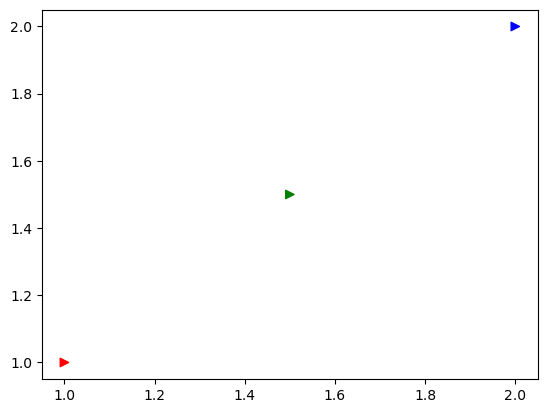

In [43]:
from matplotlib import pyplot as plt

markers, colors  = ">ox", "rgb"
X = [1,1.5,2]

# Scattering all points uniform marking, different colors
plt.scatter(X,X,marker=markers[0],c=list(colors))
# Try out different markers
#plt.scatter(X,X,marker=markers[1],c=list(colors))
#plt.scatter(X,X,marker=markers[2],c=list(colors))

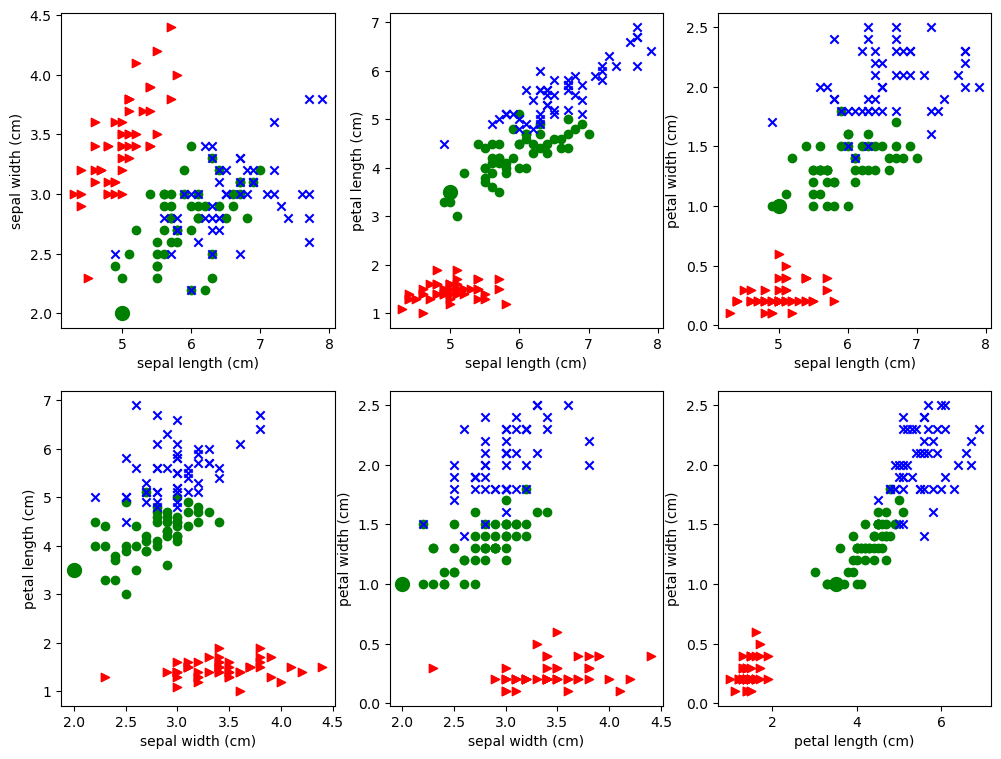

In [44]:
%matplotlib inline

import pylab 
import numpy as np
from matplotlib import pyplot as plt

# Let's make this a big figure, because there are multiple subplots
pylab.rcParams['figure.figsize'] = (12.0, 9.0)


markers, colors  = ">ox", "rgb"
# Four columns, plot two at a time.  
# This is all 6 possible pairings of the indices of the 4 cols
pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
for i,(x,y) in enumerate(pairs):
    # 6 subplots in 2x3 configuration. Each subplot pairs two iris
    # attributes we call x and y. Let's do subplot i+1 now.
    plt.subplot(2,3,i+1)
    # On this subplot we're doing 3 sets of points, each belonging to a different iris class
    # with a different color and shape used to draw the points.  To do the 3 sets, use a loop.
    # To loop through 3 sequences at once, zip them together first
    for cls,marker,clr in zip(range(3),markers,colors):
        plt.scatter(features[target == cls,x], features[target == cls,y], marker=marker, c=clr)
    # Let's draw our point P with attention-getting large SIZE.
    p_features,p_cls  = features[-90],target[-90]
    marker,clr = markers[p_cls], colors[p_cls]
    plt.scatter(p_features[x],p_features[y],marker=marker,c=clr,s=100)
    # Done with P
    # Label this subplot with the names of the two features being studied.
    plt.xlabel(feature_names[x])
    plt.ylabel(feature_names[y])
    # To make it prettier, uncomment the following & remove ticks on the x and y axis.
    #plt.xticks([])
    #plt.yticks([])
 
plt.savefig('iris_datasets_separations.png')

Notice that that big green dot P jumps around from plot to plot. It's being represented with different numerical values each time, so it jumps around the xy-plane.  In the first plot we see its sepal length/ sepal width view, which happens to be the point (5,2).  In the second plot we look at the sepal length/petal length view, which happens to be the point (5,3.5). Six different views as we scoot from subplot to subplot, all coming from the one row in the `features` table that represent P:

```
[ 5. ,  2. ,  3.5,  1. ]
```

## 3.  Linear separation

Now consider the problem of drawing straight lines to **separate** the classes.  First off it's easy to see that it's much easier to separate the red points from the blue and green points than it is to separate the blue points from the green points. As an example let's draw a pretty good line for separating the red points from the others for the second plot in
the first row.  This is the one that plots **sepal length** (x-axis) against **petal 
length** (y axis).  Note that I found the line by eyeballing the plot and using
trial and error.

In [37]:
features[-90]

array([5. , 2. , 3.5, 1. ])

Text(0, 0.5, 'petal length (cm)')

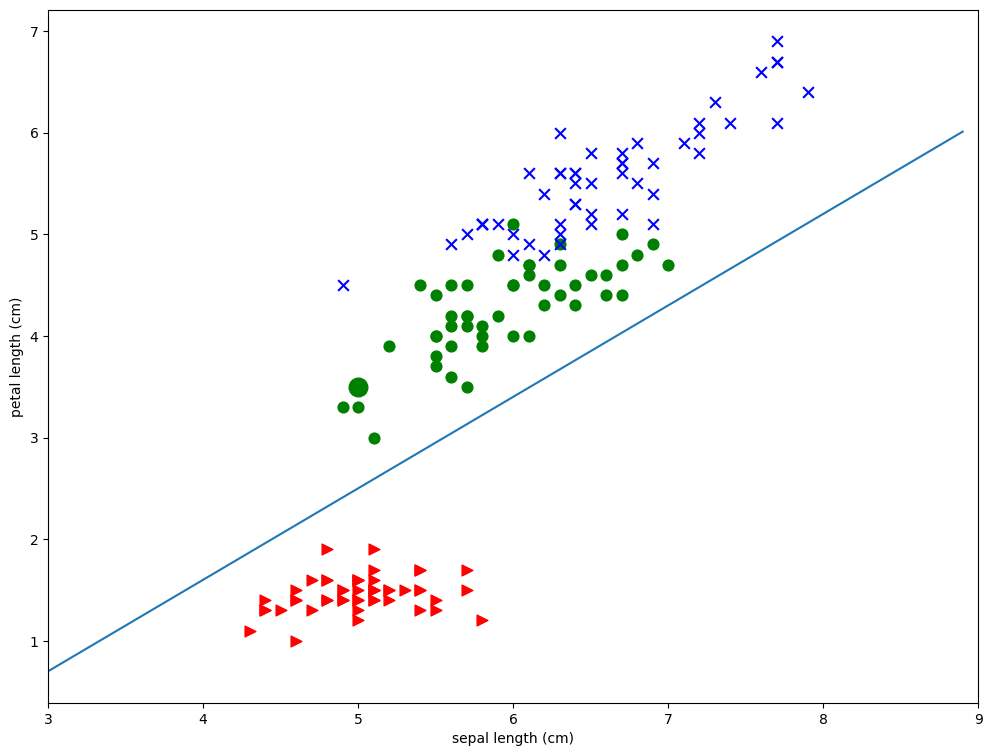

In [45]:
# After some trial & error, I decided a line specified by the following 2 numbers worked.
# m is the slope, b is where the line intercepts the y axis (not seen in the figure)
(m,b) = (.9,-2)
# The indexes for the two iris features we're using for this plot.
(p0,p1) = (0,2)
# Scatter the data points
for t,marker,c in zip(list(range(3)),">ox","rgb"):
    plt.scatter(features[target == t,p0], features[target == t,p1], 
                marker=marker, c=c,s=60) 
# Let's draw our point P with extra special attention getting large SIZE.
p_features,p_target  = features[-90],target[-90]
marker,clr = ">ox"[p_target], "rgb"[p_target]
plt.scatter(p_features[p0],p_features[p1],marker=marker,c=clr,s=180)
 
# Draw our classifier line
# We'll only draw the portion of the line relevant to the current figure.
(xmin,xmax) = (3.,9.)
# tighten the boundaries on the drawing to the same limits
plt.gca().set_xlim(xmin,xmax)
#Between xmin and xmax, mark off a set of points on the x-axis .1 apart
xvec = np.arange(xmin,xmax,.1)
# Plot a stright line with the chosen slope & intercept
plt.plot(xvec,m*xvec+b)
plt.xlabel(feature_names[p0])
plt.ylabel(feature_names[p1])

To see what this line does,  consider our example iris P.

Let's pretend we don't know the class of P, but we do know
its attributes. So we know $P$ has sepal length 5 and petal length 3.5.  

Let's plot it and use our line as a classifier.

In [39]:
p_target

1

3


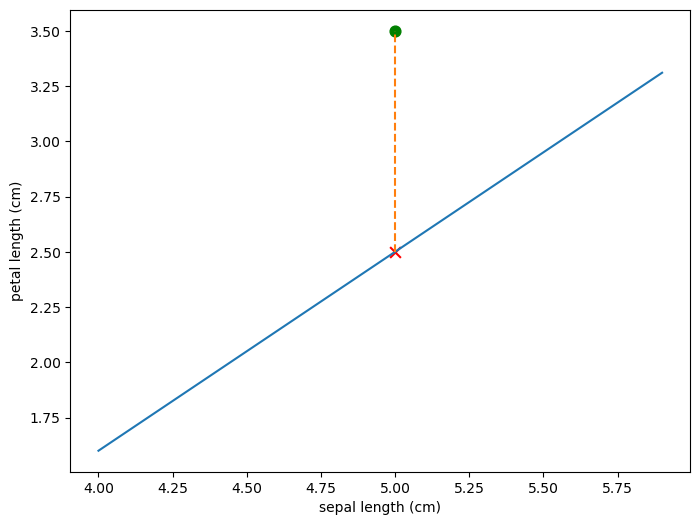

In [46]:
pylab.rcParams['figure.figsize'] = (8.0, 6.0)
# Our sample point
P = features[-90]
(xPrime,yPrime) = (P[0],P[2])
# Boundaries of what we'll draw.
(xmin,xmax) = (4.0,6.0)
# Ticks at which to place points on x- axis
xvec = np.arange(xmin,xmax,.1)
# our classifier line slope and intercept
(m,b) = (.9,-2)
#  Use (m,b) for the EQUATION of the classifier line.  
yvec = m*xvec+b
# Plot the classifier line
plt.plot(xvec,yvec)

# the point on the line below xPrime
yHat = m*xPrime + b
# Plot our example point
plt.scatter(xPrime,yPrime , marker='o', c='g',s=60) 


# Plot a point X below P, directly on the classifier line
plt.scatter([xPrime],[yHat] , marker='x', c='r',s=60) 
xvec2,yvec2 =np.array([xPrime,xPrime]),np.array([yHat,yPrime])
# Plot the dashed line from X to P
plt.plot(xvec2,yvec2,linestyle='--')
# Draw the frame around the plots TIGHT
plt.axis('tight')
plt.xlabel(feature_names[p0])
plt.ylabel(feature_names[p1])

print(y)

The representation of the iris $P$ in this plotting system is shown as the green dot.  Since the dot falls above the line we would classify it as a non-red class iris.  Also shown
(as a red X) is what the petal of length of $P$ would have to be for it to fall directly in the line.

We printed out that value before drawing the plot.  It's 2.5.  Basically for any iris
with sepal length 5, if it's petal length is greater than 2.5 we classify it as non-red;
if it's less than 2.5 we classify it as red.  The line defines a classification rule.

Moreover we can easily extend the rule to any sepal length.  In fact,
we can write a classification rule, using the equation for the line.  Let `(x',y')`
be the point to classify, and let's we call non-red the **positive class**.
Then we place `(x',y')` in the positive class whenever the following 
quantity is positive (see the definition of `yvec` in the code above):

```
y' - (.9x' - 2) = y' -.9x + 2
```

Taking our example point `(x'=5,y'=3.5)`:

```
3.5 - .9*5 + 2 = +1
```

So as desired this is positive, telling us the point falls above the line and should
be classified as non-red.

We have just created a classification rule.  Next we write a function that implements our rule.


In [47]:
def is_non_red (P):
    """
    P is a data point, all 4 attributes.
    
    Return True if P is in positive class.
    """
    return (P[2] - .9*P[0] + 2) > 0\

P = features[-90]
print('P is in positive class: {0}'.format(is_non_red(P)))

P is in positive class: True


## 4.  Relationship to regression

How is what we've done related to regression, especially linear regression?

Well, first of all, in both the linear regression case and the linear discriminant case,
we are using numerical data (a scattering of points) to try to determine a line.

We are defining the line in different ways.  In the linear regression case, we looked 
for the best line to represent the scattering of points we saw. In the linear discrimination
case, we are looking for the best line to **separate** two classes.

Just as it wasn't always possible to find a line that was a good **fit** to our scattering of data, so it isn't always possible separate a scattering of points with a line.

What we're seeing in the plots above is that, taking the features by pairs, we can't see
a good way to separate all 3 classes.

We'll validate this intuition in the next section. We'll use a program that does a kind of linear discrimination; that is, it tries to find linear separations between classes.  Instead of using Fisher's method, which is called Linear Discriminant Analysis (LDA), we'll use
something called **Logistic regression**, which has become far more popular in many applications.  The differences don't matter for our purposes,  but logistic regression is much more likely to be the method of choice in linguistic applications. 

## 5.  Linear classifier results

We're going to use `sklearn` to build a linear classifier to to separate all three classes. We're first going to use just the sepal features, to keep it visualizable.  We'll use a type of linear classifier called  a **Logistic Regression classifier**.

In [21]:
xx[0,:]

array([3.8 , 3.82, 3.84, 3.86, 3.88, 3.9 , 3.92, 3.94, 3.96, 3.98, 4.  ,
       4.02, 4.04, 4.06, 4.08, 4.1 , 4.12, 4.14, 4.16, 4.18, 4.2 , 4.22,
       4.24, 4.26, 4.28, 4.3 , 4.32, 4.34, 4.36, 4.38, 4.4 , 4.42, 4.44,
       4.46, 4.48, 4.5 , 4.52, 4.54, 4.56, 4.58, 4.6 , 4.62, 4.64, 4.66,
       4.68, 4.7 , 4.72, 4.74, 4.76, 4.78, 4.8 , 4.82, 4.84, 4.86, 4.88,
       4.9 , 4.92, 4.94, 4.96, 4.98, 5.  , 5.02, 5.04, 5.06, 5.08, 5.1 ,
       5.12, 5.14, 5.16, 5.18, 5.2 , 5.22, 5.24, 5.26, 5.28, 5.3 , 5.32,
       5.34, 5.36, 5.38, 5.4 , 5.42, 5.44, 5.46, 5.48, 5.5 , 5.52, 5.54,
       5.56, 5.58, 5.6 , 5.62, 5.64, 5.66, 5.68, 5.7 , 5.72, 5.74, 5.76,
       5.78, 5.8 , 5.82, 5.84, 5.86, 5.88, 5.9 , 5.92, 5.94, 5.96, 5.98,
       6.  , 6.02, 6.04, 6.06, 6.08, 6.1 , 6.12, 6.14, 6.16, 6.18, 6.2 ,
       6.22, 6.24, 6.26, 6.28, 6.3 , 6.32, 6.34, 6.36, 6.38, 6.4 , 6.42,
       6.44, 6.46, 6.48, 6.5 , 6.52, 6.54, 6.56, 6.58, 6.6 , 6.62, 6.64,
       6.66, 6.68, 6.7 , 6.72, 6.74, 6.76, 6.78, 6.

In [19]:
yy.shape

(171, 231)

In [23]:
set(tuple(Z.ravel()))

{0, 1, 2}

([], [])

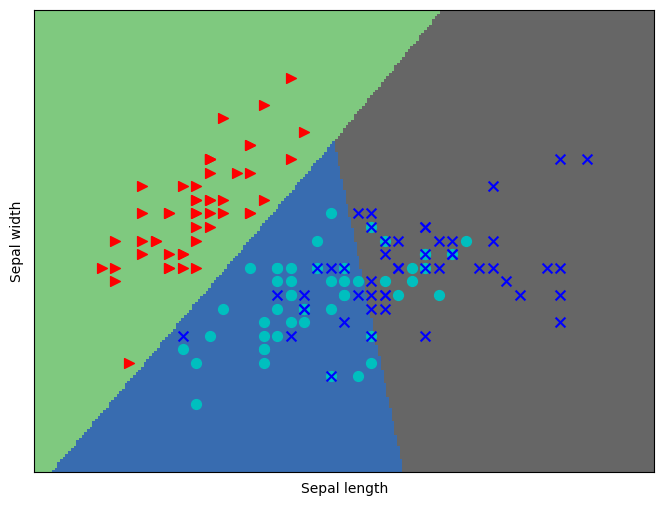

In [49]:
from sklearn import linear_model
#pylab.rcParams['figure.figsize'] = (12.0, 9.0)

#  Use just the first 2 columns as predictors
#  Why?  So we can draw this!
X = features[:,:2]
Y = target



# we create an instance of a Logistic Regression Classifier.
logreg = linear_model.LogisticRegression(C=1e5,solver='lbfgs',multi_class='auto')

# we fit the data.
logreg.fit(X, Y)


# Apply the classifier's decision function to xx,yy.   Z contains
# the predicted classes for the 2D points in the  mesh

# x and y here refer to the x-,y- axis of the drawing below
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh

################################################################
#  Dont worry too  much about this part of the code.  Meshes
#  are a mesh-y topic.  They are the 2D version of aranges.
# xx and yy define a mesh: a rectangular region covering  all of
# the training data X.  xx contains the x coords, yy the y coords.
# xx[0,:] is the x coords of the first row of the rectangle.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
##  End of meshy stuff xx,yy are the points we're going to classify,±
##  So that we can color entire regions of the plot.

# (conceptually, ALL the points in the 2D region defined by the training data).
# So set(tuple(Z.ravel())) is {0,1,2} the 3 iris classes.
# The result Z is an array storing  the predicted class for every point in xx,yy
# We use .ravel() to flatten out 2D matrices xx and yy to concat into a 2D
# matrix 
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.  We'll color EACH point in xx,yy
# according to its class in Z.
Z = Z.reshape(xx.shape)
# Use a Qualitive Colormap ()
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel1)
#colors2 = colors
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Accent)
colors2 = 'rcb'
# Also plot the training points, coloring them according to their  TRUE classes.
for cls,marker,clr in zip(list(range(3)),markers,colors2):
        plt.scatter(X[target == cls,0], X[target == cls,1], marker=marker, c=clr, s=50)

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

The differently colored regions represent the areas the classifier has reserved for particular classes, and the dots are our training data, colored by species.  We see that all our worries are validated.  The classifier separates the red class off nicely, and has trouble discriminating the darkblue x-class and lightblue cicle-class.  

This coloring also makes it clear that it's not 
really the classifier's problem: These two dimensions are insufficient to discriminate the three species. In the blue and gray regions, look for darkblue Xs
superimposed on lightblue circles.  These are points from our training data that belong to two different species but have exactly the same coordinates in these 2 dimensions. 
In other words, given just the sepal length and sepal width, there is no way to tell these
irises apart.

Can we quantify what's going on? Certainly.

Here's how to find out our score.

In [50]:
from sklearn.metrics import accuracy_score
# Rerun prediction on just the training data.
logreg.fit(X, Y)
predicted = logreg.predict(X)
# Y has the right answers.
accuracy_score(Y,predicted)

0.8333333333333334

Well, we went and cheated by evaluating our score on just the training data,
and we **still** didn't do very well.  Only 80% correct!

Maybe our problem is that we keep using only two features at a time. What if we use **all**
the features at once?  Please note how simple the following code is.  We are basically starting from scratch, using all our data, and all our features, and testing.

## The most important part of this notebook

In [31]:
# Go back to using all 4 features.  Compare the definition of X used the plot above.
X = features
Y = target
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs',multi_class='auto')
logreg.fit(X, Y)
predicted = logreg.predict(X)
accuracy_score(Y,predicted)

0.9866666666666667

Yep,  that was our problem.  Our accuracy is now 98%!

And so we pause for a moment to take in one of the central lessons of multivariate statistics.  Using more variables can help.  Bigtime.  It doesn't always help, but as long
as we're getting new independent informatioon from the new features, it's worth
trying.

We started out essentially asking the question, what linear function of two 
of these variables can best separate these classes?  And we tried all possible systems using two features and didn't do very well.  But then we switched to asking what linear function
of all 4 variables can best separate these variables? And we did **much** better.

So why didn't we do this to start with?  And why did the code get so much simpler?

Second question, first, because the two answers are related.  The code got much simpler
because we threw out the visualization code.  And we threw out the visualization code
because we switched to a system that was much harder to visualize.  We essentially went from representing our code in 2 dimensions (so that 
we could plot every point on an the xy plane) to representing it in 4 dimensions.
Try and visualize 4 dimensions!  Pretty hard.  And that's the answer
to the first question.  We didn't do it this way to start with because
we wanted something we could visualize, and that proved helpful, because there
were insights the visualizations gave us, especially about the red class.

And therein lies one problem with switching to 4 dimensions.  We've lost our capacity
to glean insights from the data, at least with the tools we've looked at till now.
We don't really know what relationships got us over the hump in classifying
irises.

So lesson number one is that more variables can help.  And lesson number
two is that there are perils involved in using more variables.  Actually 
we haven't even scratched the surface of the many perils involved in higher-dimensional
data, but we've identified an important one.  Using more variables makes things
more complicated, and that makes it harder to understand what's going on.
At some point we are going to have turn around and explain our results
to an audience waiting with baited breath, and you have be **very** careful when explaining
multivariate results.  Visualization is a big help at explaining complicated
relationships, so losing the ability to visualize is not a small loss,
especially since what real life problems often involve is not yes/no classifications,
but insight.  More on the problem of visualizing higher-dimensional data later in
the course.

In the meantime, to try to recover a little insight into what is going on with
a completely visualizable representation of the iris data, have a look at the appendix.

## Appendix A Using different types of SVM

We will explore some of the consequences of using different types of SVMs in the next notebook (linear_classifier_svm).

Here we just give the flavor of how to use different classifiers (in particular different SVMs)
in `scikit_learn`.

Note:  Inthe figure below there are two plots labeled *SVC with Linear Kernal* 
and Linear SVC (Linear kernel).  I don't really understand how these two models
differ, other than that they are different Support Vector Machine (SVM) implementations
both available in `scikit learn`.

Automatically created module for IPython interactive environment


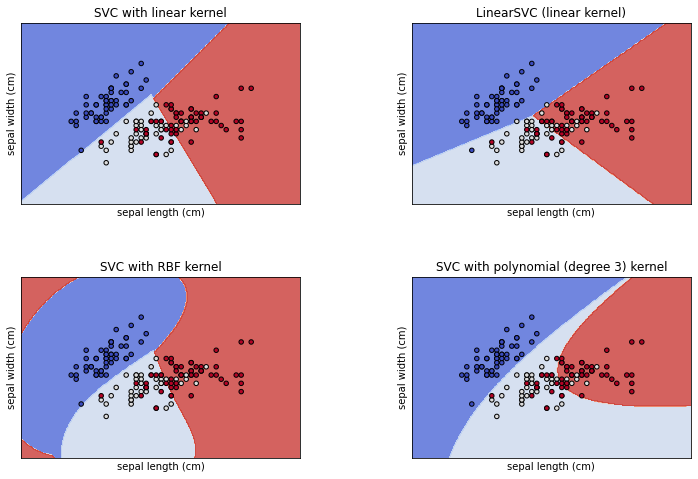

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. 
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2,figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

x_att,y_att = 0,1
X0, X1 = X[:, x_att], X[:, y_att]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #ax.set_xlabel('Sepal length')
    #ax.set_ylabel('Sepal width')
    ax.set_xlabel(iris.feature_names[x_att])
    ax.set_ylabel(iris.feature_names[y_att])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

#### Notes on hacking numpy arrays

In [67]:
import numpy as np

# Cook up random 1d array
a_1D = np.random.rand(4,)

# make it 4 x 1
a_nrows = a_1D.shape[0]
a_2D = a_1D.reshape((a_nrows,1))

In [68]:
a_1D

array([0.82785793, 0.02199211, 0.02607832, 0.18824968])

In [69]:
a_1D.shape

(4,)

In [70]:
a_2D

array([[0.82785793],
       [0.02199211],
       [0.02607832],
       [0.18824968]])

In [10]:
a_2D.shape

(4, 1)

In [71]:
# Cook up random 2d arrays of different shapes
b_2D_1 = np.random.rand(4,2)
b_2D_2 = np.random.rand(4,3)
b_2D_3 = np.random.rand(2,2)

In [72]:
b_2D_1

array([[0.58968585, 0.3780283 ],
       [0.92069582, 0.64670967],
       [0.717604  , 0.2530142 ],
       [0.08233576, 0.34751584]])

In [73]:
b_2D_2

array([[0.44547243, 0.85595194, 0.99244395],
       [0.59038664, 0.99123087, 0.40637481],
       [0.86445582, 0.25160339, 0.11395818],
       [0.98553047, 0.89830304, 0.52353679]])

In [74]:
b_2D_3

array([[0.74797376, 0.539302  ],
       [0.87940524, 0.64808369]])

Concatenate columnwise

In [49]:
np.hstack([b_2D_1, b_2D_2])

array([[0.50243424, 0.9311518 , 0.98214676, 0.58644108, 0.39514477],
       [0.70095486, 0.29907664, 0.38201942, 0.44371491, 0.83550265],
       [0.14189844, 0.160513  , 0.8608271 , 0.18844577, 0.71184684],
       [0.01641225, 0.3151915 , 0.02145551, 0.06931183, 0.69261826]])

In [154]:
b_2D_1.shape, b_2D_2.shape

((4, 2), (4, 3))

In [71]:
b_2D_3

array([[0.30351754, 0.76798279],
       [0.5141392 , 0.9277491 ]])

A Value error. Hstacking 4x2 wiwth 2X2.  Num rows must gree.

In [74]:
#np.hstack([b_2D_1, b_2D_3])

A Value error because b_2D_1 and a_1D do not have the same number of dimensions
(2D vs 1D)

In [35]:
#np.hstack([b_2D_1, a_1D])

Concatenating rowwise. 4x2 with 2x2 ok.  Num cols agrees.

In [75]:
np.vstack([b_2D_1, b_2D_3,])

array([[0.58968585, 0.3780283 ],
       [0.92069582, 0.64670967],
       [0.717604  , 0.2530142 ],
       [0.08233576, 0.34751584],
       [0.74797376, 0.539302  ],
       [0.87940524, 0.64808369]])

Equivalently use `np.concatenate`

In [64]:
# concat 4x2 with 2x2.  Rowwise concat (like vstack)
np.concatenate([b_2D_1, b_2D_3,])

array([[0.51743987, 0.81270196],
       [0.62356152, 0.15820932],
       [0.55381664, 0.10131331],
       [0.85201144, 0.01164034],
       [0.30351754, 0.76798279],
       [0.5141392 , 0.9277491 ]])

In [66]:
# concat 4x2 with 4x3
# Default value for axis is 0. So this is a value error w/o axis=1
np.concatenate([b_2D_1, b_2D_2,],axis=1)

array([[0.51743987, 0.81270196, 0.40230919, 0.07547772, 0.95227653],
       [0.62356152, 0.15820932, 0.37852094, 0.96461176, 0.92121527],
       [0.55381664, 0.10131331, 0.05654117, 0.9910145 , 0.03333896],
       [0.85201144, 0.01164034, 0.31244837, 0.20161952, 0.53110018]])

#### Recognizing adjectives

We train a  classifier to recognize adjectives just by their word shape, inspired
by little word clusters like the following:

```
curious
odious
ruinous
heinous
```

or 

```
possible
miserable
doable
bankable
visible
````

or 

```
baggy
squishy
funky
briny
spikey
```

or 

```
salient
extant
constant
divergent
urgent
important
```

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [123]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/gawron/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gawron/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [124]:
from nltk.corpus import brown
brown_tagged = brown.tagged_words(tagset='universal')
digit = set('01234567879')
tagged_vocab = sorted(list(set(brown_tagged)))
empty = set()
punct = set("\":+;&()*\$\.\,\!/?'-")

adj_vocab = [(word,1) for (word,tag) in tagged_vocab if (tag=='ADJ') 
               and digit.intersection(word) == empty
               and punct.intersection(word) == empty
              ]
other_vocab = [(word,0) for (word,tag) in tagged_vocab if (tag !='ADJ') 
               and digit.intersection(word) == empty
               and punct.intersection(word) == empty
               ]
print(len(adj_vocab))
print(len(other_vocab))

6518
43468


In [125]:
print(len(brown_tagged),len(tagged_vocab))
brown_tagged[:20]

1161192 59962


[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP')]

In [126]:
print(len(other_vocab),len(adj_vocab))
adj_vocab[:10]

43468 6518


[('Abnormal', 1),
 ('Aboveground', 1),
 ('Abstract', 1),
 ('Acceptable', 1),
 ('Accidental', 1),
 ('Acoustical', 1),
 ('Active', 1),
 ('Actual', 1),
 ('Additional', 1),
 ('Adequate', 1)]

In [127]:
other_vocab[:10]

[('A', 0),
 ('A', 0),
 ('A', 0),
 ('AA', 0),
 ('AAA', 0),
 ('AB', 0),
 ('ABC', 0),
 ('ABO', 0),
 ('ACS', 0),
 ('ACTH', 0)]

In [128]:
# CountVectorizer:  Read up on the diff between analyzer char and char_wb.
# As an example, with bigram features: analyzer char_wb given "Mark" will yield "k " 
# as a feat and the corresponding feature will be "k" with char.  Essentially
# char_wb pads peripheral chars, thereby introducing word boundary information.
# Since feat "a " means "a" as the last letter, this rep allows clf to learn
# this as a female name cue.

#cv = CountVectorizer(ngram_range=(1,2),analyzer='char_wb')
#cv = CountVectorizer(ngram_range=(2,3),analyzer='char_wb')
cv = CountVectorizer(ngram_range=(2,4),analyzer='char_wb')

data = adj_vocab + other_vocab
# A squence of strings; a sequence of labels
words, tags = zip(*data)

X_train, X_test, y_train, y_test = \
  train_test_split(words, tags, test_size=0.05, random_state=42)

##  Train it to learn a fixed set of features
X_train_m = cv.fit_transform(X_train)

## Now use only those features on the test set
X_test_m = cv.transform(X_test)

In [131]:
for ft in cv.get_feature_names_out():
    print(ft)

 [
 [ 
 ]
 ] 
 `
 ``
 `` 
 a
 a 
 aa
 aa 
 aaa
 aah
 aar
 ab
 ab 
 aba
 abb
 abc
 abd
 abe
 abh
 abi
 abj
 abl
 abn
 abo
 abr
 abs
 abu
 aby
 ac
 aca
 acc
 ace
 ach
 aci
 ack
 aco
 acq
 acr
 act
 acu
 ad
 ad 
 ada
 adc
 add
 ade
 adh
 adi
 adj
 adl
 adm
 adn
 ado
 adr
 ads
 adu
 adv
 ae
 aec
 aeg
 aeo
 aer
 aes
 aet
 af
 af 
 afa
 aff
 afg
 afi
 afl
 afo
 afr
 aft
 ag
 aga
 age
 agg
 agh
 agi
 agl
 agn
 ago
 agr
 agu
 ah
 ah 
 aha
 ahe
 ahm
 ahr
 ai
 ai 
 aia
 aic
 aid
 aie
 aik
 ail
 aim
 ain
 air
 ais
 aj
 aj 
 aja
 ajb
 ak
 aki
 aku
 al
 al 
 ala
 alb
 alc
 ald
 ale
 alf
 alg
 ali
 alk
 all
 alm
 alo
 alp
 alr
 als
 alt
 alu
 alv
 alw
 am
 am 
 ama
 amb
 ame
 ami
 amm
 amo
 amp
 amr
 ams
 amt
 amu
 amy
 an
 an 
 ana
 anc
 and
 ane
 ang
 anh
 ani
 ank
 ann
 ano
 ans
 ant
 anv
 anx
 any
 anz
 ao
 aor
 aou
 ap
 ap 
 apa
 ape
 aph
 api
 apl
 apo
 app
 apr
 aps
 apt
 aq
 aqu
 ar
 ara
 arb
 arc
 ard
 are
 arf
 arg
 arh
 ari
 ark
 arl
 arm
 arn
 aro
 arp
 arr
 ars
 art
 aru
 ary
 as
 as 
 

In [132]:
#clf = MultinomialNB()
#clf = RidgeClassifier()
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_m, y_train)

# Test
y_predicted = clf.predict(X_test_m)

accuracy_score(y_predicted,y_test)

0.9288

In [133]:
ticklers = ['onerous','wettest', 'salient', 'farmable','kinky','exultant','sextant']
test2 = cv.transform(ticklers)
clf.predict(test2)

array([1, 1, 1, 1, 0, 1, 1])

In [134]:
[wd for wd in ticklers if wd in X_train]

[]

In [26]:
errs = [(wd,y_predicted[i]) for (i,wd) in enumerate(X_test) if y_test[i] != y_predicted[i]]

In [142]:
errs

[('abstention', 1),
 ('Duplicate', 0),
 ('Venable', 1),
 ('senior', 1),
 ('theatergoing', 0),
 ('normal', 1),
 ('variable', 1),
 ('encouraging', 0),
 ('Confucian', 0),
 ('Indigo', 0),
 ('maggoty', 0),
 ('Prexy', 1),
 ('initiative', 1),
 ('under', 0),
 ('flyaway', 0),
 ('Cassite', 0),
 ('backward', 0),
 ('Ivory', 1),
 ('random', 0),
 ('awash', 0),
 ('Corporal', 1),
 ('barefoot', 1),
 ('understanding', 0),
 ('Tacloban', 1),
 ('daily', 1),
 ('open', 0),
 ('unsmilingly', 1),
 ('jaunty', 0),
 ('grizzled', 0),
 ('tight', 0),
 ('Most', 0),
 ('Red', 0),
 ('saucy', 0),
 ('unnumbered', 0),
 ('unquenched', 0),
 ('Morningstar', 1),
 ('wan', 0),
 ('halfway', 0),
 ('tardy', 0),
 ('unsolder', 1),
 ('Small', 0),
 ('appetites', 1),
 ('immense', 0),
 ('bombastic', 0),
 ('Mobile', 1),
 ('Portuguese', 0),
 ('relative', 1),
 ('fluid', 1),
 ('shorter', 0),
 ('appetite', 1),
 ('curbside', 1),
 ('capillary', 1),
 ('pert', 0),
 ('bodily', 1),
 ('Joshual', 1),
 ('unwaveringly', 1),
 ('chill', 0),
 ('detective',

##  Precision,  Accuracy, and Recall

The next cell takes the first step toward testing a classifier a little more seriously.  It defines some code for evaluating classifier output.  The evaluation metrics defined are precision, recall, and accuracy.  Call the examples the system predicts to be positive (whether correctly or not) ppos and and the examples it predicts to be negative pneg; consider the following performance on 100 examples:

$$\begin{array}[t]{ccc} &  pos &neg\\ ppos& 31 & 5\\ pneg & 14  & 50 \end{array}$$

The performance of the system has been sorted into 4 classes:

$$\begin{array}[t]{ccc} &  pos &neg\\ ppos& tp & fp\\ pneg & fn & tn \end{array}$$

The $tp$ and $tn$ examples (true positive and true negative) are those the system labeled correctly,
while $fp$ and $fn$ (false positive and false negative) are those labeled incorrectly.
Let N stand for the total number of examples,
100 in our case. 

The three most important measures of system performance are:
  
  1. **Accuracy**: Accuracy is the percentage of correct examples out of the total corpus 

  $$Acc = \frac{tp+tn}{N} = \frac{31 +50}{100}$$ 
  
  This is .81 in our case.

  2. **Precision**: Precision is the percentage of true positives out of all positive guesses the system made 
  
  $$Prec= \frac{tp}{tp + fp} = \frac{31}{31+5}.$$
  
  This is .86 in our case.  Precision is sometimes called **sensitivity**.  It is also the probability that
  an instance classified as relevant actually is relevnt.
  
  3. **Recall**: Recall is the percentage of true positives out of all positives 
  
  $$Rec = \frac{tp}{tp + fn} = \frac{31}{31+14}.$$
  
  This is .69 in our case. Recall is sometimes called **sensitivity**.  It is also the probability that
  a relevant instance will be tagged as relevant.


In [103]:
# Eval metrics
precision_a = precision_score(y_test,y_predicted)
recall_a = recall_score(y_test,y_predicted)
precision_o = precision_score(y_test,y_predicted,pos_label=0)
recall_o = recall_score(y_test,y_predicted,pos_label=0)

print(f"Precision(adj): {precision_a:.2f} Recall(adj): {recall_a:.2f}")
print(f"Precision(non): {precision_o:.2f} Recall(non): {recall_o:.2f}")

Precision(adj): 0.76 Recall(adj): 0.60
Precision(non): 0.95 Recall(non): 0.97


#### Results

Multinomial NB

```
Precision(adj): 0.58 Recall(adj): 0.61
Precision(non): 0.95 Recall(non): 0.94
```

Ridge

```
Precision(adj): 0.71 Recall(adj): 0.62
Precision(non): 0.95 Recall(non): 0.96
```

Log. Regr:

```
Precision(adj): 0.76 Recall(adj): 0.60
Precision(non): 0.95 Recall(non): 0.97
```

In [108]:
###         | pneg     ppos
### ------------------------------
###   neg   |  tn       fp
###   pos   |  fn       tp 

cm = confusion_matrix(y_test,y_predicted)
cm

array([[2140,   56],
       [ 122,  182]])

In [105]:
sum(y_predicted) == 56+182

True

In [106]:
sum(y_test)  == 122+182

True

In [119]:
# tp/(tp+fp) = Prec
(r,c) = cm.shape
pos_i = r-1
# assumption r=c (sq. matrix)
prec = cm[pos_i,pos_i]/cm[:,pos_i].sum()
prec 

0.7647058823529411

In [116]:
(r,c) = cm.shape
# assumption r=c (sq. matrix)
acc = cm[range(r),range(r)].sum()/cm.sum()
acc

0.9288

In [122]:
rec = cm[pos_i,pos_i]/cm[pos_i,:].sum()
rec

0.5986842105263158